# Uses ROMS Surface variables for Spectral Analysis
#### Computes SST'xHFX' and regression coefficient

In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
from scipy.interpolate import griddata
from matplotlib.colors import LogNorm
import warnings
import sys
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle
from romspickle import ogive
import xroms
from dask.diagnostics import ProgressBar
warnings.filterwarnings("ignore")
import pyspec as pyspec

In [2]:

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

In [3]:

path='/data/pacific/lrenault/SASI/CROCO/FULL/'
listm=glob(path+'surf*.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_mfdataset(listm[1:],data_vars='minimal')

path='/data/pacific/lrenault/SASI/CROCO/SMTH/'
listt=glob(path+'surf*SASI_6h_his_20*_*.nc');listt.sort()
listt.append('/data/pacific/lrenault/SASI/CROCO/SMTH/surf_SASI_6h_his_2012-07.nc')
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_mfdataset(listt[1:],data_vars='minimal')

In [4]:
dxx=0.5
dyy=dxx

In [5]:
import datetime

# t_ind=pd.DatetimeIndex(varf.time_counter.compute())
t_ind=varf.time_counter.groupby("time_counter.dayofyear").mean()
t_ind_h=varf.time_counter


mon_ind=t_ind.dt.month
mes=np.array([12,1,2,3,4,5,6,7])
mes_str=['Dec/11','Jan/12','Feb/12','Mar/12','Apr/12','May/12','Jun/12','Jul/12']

## Spectral Analysis

### Temperature Spectra

In [6]:
chunks_new={'time_counter':10}

In [7]:
%%time


tf=varf.temp#.groupby("time_counter.dayofyear").mean()
tf=tf.chunk(chunks=chunks_new);
tf=tf[:,120:-120,120:800].compute();

tt=vart.temp#.groupby("time_counter.dayofyear").mean()
tt=tt.chunk(chunks=chunks_new);
tt=tt[:,120:-120,120:800].compute();

CPU times: user 6.41 s, sys: 17.3 s, total: 23.8 s
Wall time: 1min 35s


In [10]:
nf=2
wdws='hann' #'flattop','hann'
wdw_cor=True
scl='density'

In [9]:


with ProgressBar():
    TTf=xrft.isotropic_power_spectrum(tf.drop(['nav_lat_rho','nav_lon_rho']),
                                      dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

    TTt=xrft.isotropic_power_spectrum(tt.drop(['nav_lat_rho','nav_lon_rho']),
                                      dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

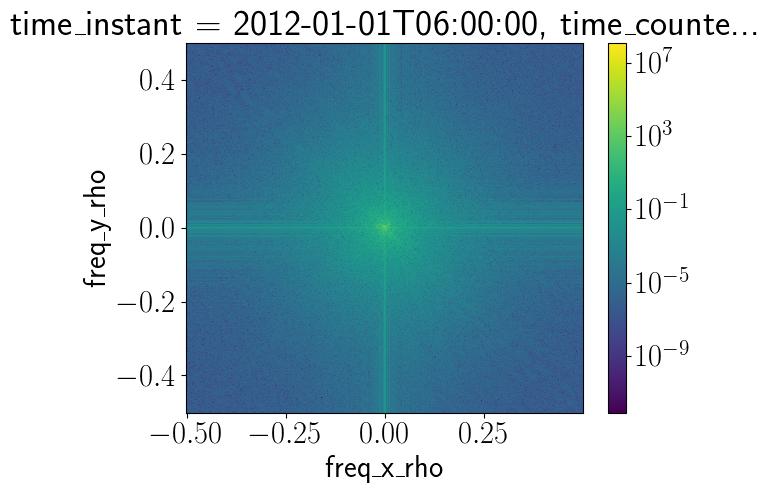

In [32]:
# var=xrft.isotropize(tf[0].drop(['nav_lat_rho','nav_lon_rho']),nfactor=nf,fftdim=['y_rho','x_rho'])
var_test=xrft.power_spectrum(tf[0].drop(['nav_lat_rho','nav_lon_rho']),dim=['y_rho','x_rho'])
var_test.plot(norm=LogNorm())

In [153]:
k = tf['x_rho']
l = tf['y_rho']

N = [k.size, l.size]
nbins = int(min(N) / nf)

In [223]:
nbins=200

In [224]:
binned = pd.cut(np.ravel(TTf.freq_r), bins=nbins)

In [225]:
freq_radial=np.sqrt(var_test.freq_x_rho**2 + var_test.freq_y_rho**2)

In [226]:
sizes_ratio=np.array([len(freq_radial.data[((freq_radial>=binz.left)&(freq_radial<=binz.right)).data]) for binz in binned])

In [231]:
sizes_ratio

array([  38,   38,   68,  100,  134,  170,  170,  202,  236,  284,  310,
        312,  312,  382,  406,  422,  502,  506,  506,  516,  586,  606,
        646,  678,  678,  718,  698,  800,  830,  840,  884,  884,  922,
        954,  932, 1024, 1078, 1078, 1052, 1142, 1158, 1116, 1248, 1248,
       1262, 1286, 1324, 1524, 1116, 1116, 1708, 1188, 1784, 1210, 1884,
       1884, 1298, 1950, 1336, 1342, 2086, 2086, 1436, 2160, 1442, 2228,
       1538, 1538, 2340, 1566, 2408, 1588, 2494, 1728, 1728, 2552, 1698,
       2664, 1838, 2712, 2712, 1850, 2816, 1860, 2914, 1980, 1980, 2996,
       1990, 3044, 2102, 3144, 3144, 2114, 3200, 2146, 3354, 2236, 2236,
       2242, 3420, 2330, 3500, 2358, 2358, 3564, 2408, 3654, 2510, 3772,
       3772, 2498, 3828, 2618, 3888, 2606, 4016, 4016, 2680, 4070, 2798,
       4172, 2738, 2738, 4256, 2882, 4324, 2870, 4444, 4444, 2940, 4494,
       3058, 4540, 3050, 3050, 3126, 4676, 3114, 4832, 3164, 3164, 4828,
       3304, 4932, 3312, 4974, 4974, 3386, 5144, 33

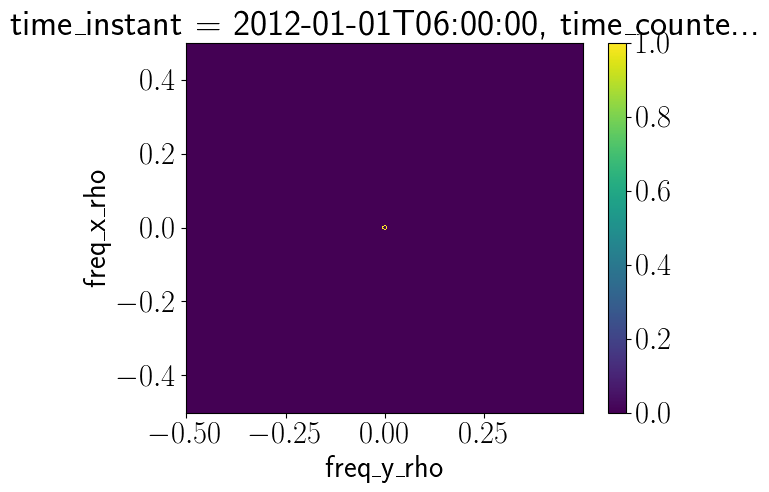

In [233]:
((freq_radial>=binned[2].left)&(freq_radial<=binned[2].right)).plot()

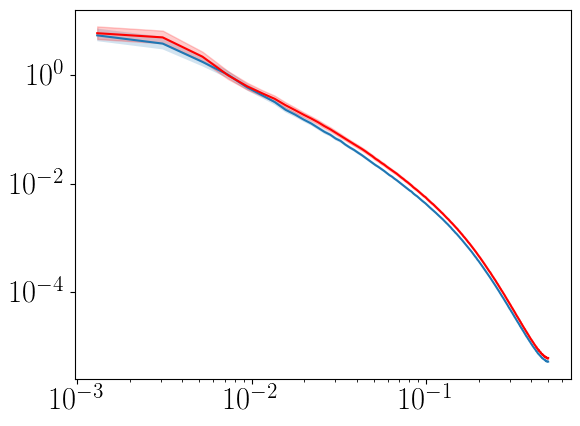

In [230]:
from pyspec import spectrum as spec
varf=spec.spec_error(TTf.mean(axis=0).data,sn=sizes_ratio)
plt.plot(TTf.freq_r,TTf.mean(axis=0))
plt.fill_between(TTf.freq_r,varf[0],varf[1],alpha=0.2)


vart=spec.spec_error(TTt.mean(axis=0).data,sn=sizes_ratio)
plt.plot(TTt.freq_r,TTt.mean(axis=0),'r')
plt.fill_between(TTt.freq_r,vart[0],vart[1],alpha=0.2,color='r')

plt.xscale('log')
plt.yscale('log')

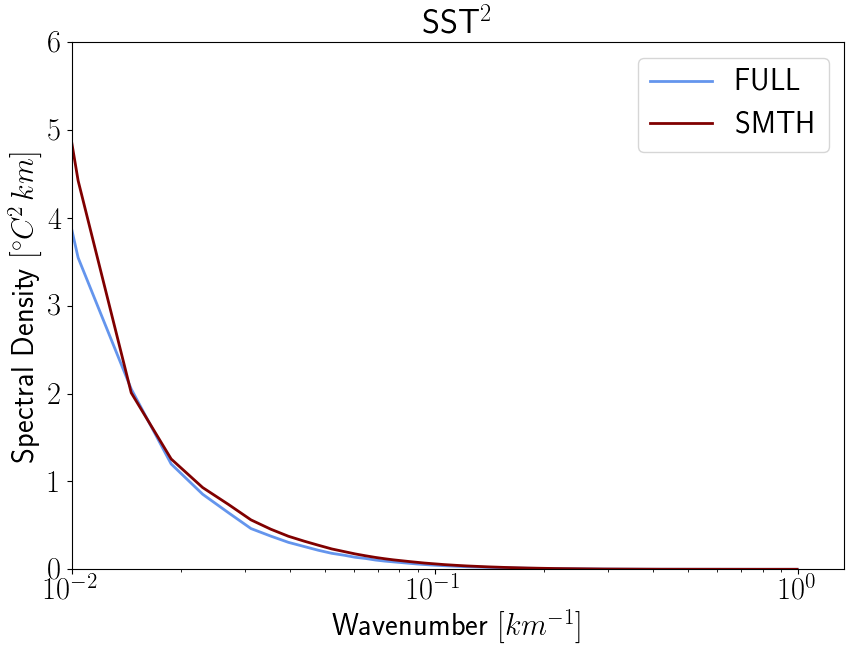

In [222]:
plt.figure(figsize=(9,7))


plt.plot(TTf.freq_r/dxx,TTf.mean(axis=0)/dxx,label='FULL',linewidth=2,color='cornflowerblue')
plt.plot(TTt.freq_r/dxx,TTt.mean(axis=0)/dxx,label='SMTH',linewidth=2,color='maroon')


plt.legend()

# plt.yscale('log')
plt.xscale('log')


# plt.grid()
# plt.title('Full Period {0}'.format(varr))
# plt.xlim(-5,-3)
# plt.xticks(np.array([-2,-1]),[r'10$^{-2}$',r'10$^{-1}$'])
# plt.yticks(np.array([-3,-1,1,3,6]),[r'10$^{-3}$',r'10$^{-1}$',r'10$^{1}$',r'10$^{3}$',r'10$^{6}$'])


plt.title(r'SST$^{2}$',fontsize=25)
plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')
plt.ylabel(r'Spectral Density $[^{\circ}C^{2}\,km]\,$',fontweight='bold')

plt.xlim(1/100,0)
plt.ylim(0,6)
plt.tight_layout()
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/Total_avg_SST.png')

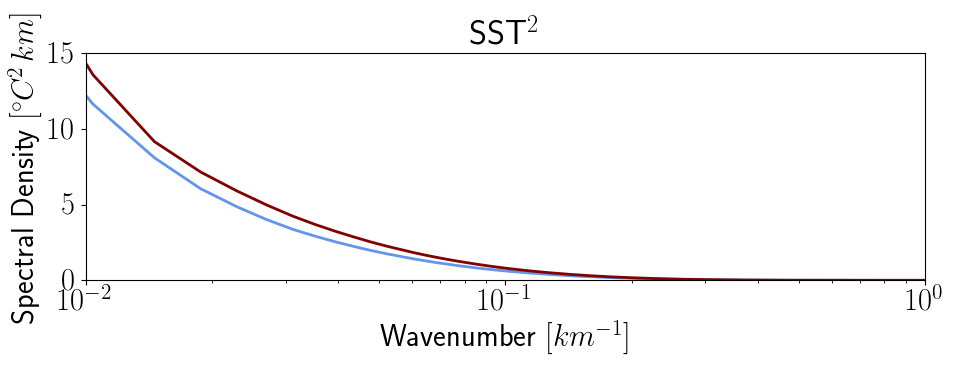

In [21]:
TOf=ogive(TTf.freq_r/dxx,TTf.mean(axis=0)/dxx)
Kx=TTf.freq_r/dxx
TOt=ogive(TTt.freq_r/dxx,TTt.mean(axis=0)/dxx)

fig,ax = plt.subplots(figsize=(10,4))
ax.plot(Kx,TOf,label='FULL',linewidth=2,color='cornflowerblue')
ax.plot(Kx,TOt,label='SMTH',linewidth=2,color='maroon')
ax.set_xticks(np.array([-2,-1]))
ax.set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])
ax.set_title(r'SST$^{2}$',fontsize=25)
ax.set_xlabel(r'Wavenumber $ [km^{-1}]$',fontweight='bold')
ax.set_ylabel(r'Spectral Density $[^{\circ}C^{2}\,km]\,$',color="k")

# ax.set_ylabel(r'$ $}',color="k",fontsize=15,fontweight='bold')
ax.set_xscale('log')

ax.set_xlim(1e-2,1)
ax.set_ylim(0,15)
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/ogives/Ogive_avg_SST.png')

### Calculating VBP

###### Not a reliable analysis, since there is a w BC for ROMS. Use 100m integrated version instead.

In [9]:
rhof=varf.rho#.groupby("time_counter.dayofyear").mean()
rhof=rhof.chunk(chunks=chunks_new);
rhof=rhof[:,120:-120,120:800].compute();

rhot=vart.rho#.groupby("time_counter.dayofyear").mean()
rhot=rhot.chunk(chunks=chunks_new);
rhot=rhot[:,120:-120,120:800].compute();

In [15]:
%%time
wf=varf.w#.groupby("time_counter.dayofyear").mean()
wf=wf.chunk(chunks=chunks_new);
wf=wf[:,120:-120,120:800].compute();

wt=vart.w#.groupby("time_counter.dayofyear").mean()
wt=wt.chunk(chunks=chunks_new);
wt=wt[:,120:-120,120:800].compute();



CPU times: user 6.33 s, sys: 10.7 s, total: 17 s
Wall time: 1min 29s


In [10]:
bf=xroms.buoyancy(rhof)#[:,1:-1,:]
bt=xroms.buoyancy(rhot)#[:,1:-1,:]

In [11]:
%%time
with ProgressBar():
    Bf=xrft.isotropic_power_spectrum(bf.drop(['nav_lat_rho','nav_lon_rho']),
                                      dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

    Bt=xrft.isotropic_power_spectrum(bt.drop(['nav_lat_rho','nav_lon_rho']),
                                      dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

    Wf=xrft.isotropic_power_spectrum(wf.drop(['nav_lat_rho','nav_lon_rho']),
                                      dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

    Wt=xrft.isotropic_power_spectrum(wt.drop(['nav_lat_rho','nav_lon_rho']),
                                      dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

NameError: name 'wf' is not defined

In [27]:
%%time
with ProgressBar():
    VBPf=xrft.isotropic_cross_spectrum(wf.drop(['nav_lat_rho','nav_lon_rho']),bf.drop(['nav_lat_rho','nav_lon_rho']),
                                      dim=['y_rho','x_rho'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real
    
    VBPt=xrft.isotropic_cross_spectrum(wt.drop(['nav_lat_rho','nav_lon_rho']),bt.drop(['nav_lat_rho','nav_lon_rho']),
                                      dim=['y_rho','x_rho'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real

CPU times: user 51min 38s, sys: 2h 34min 41s, total: 3h 26min 20s
Wall time: 3min 46s


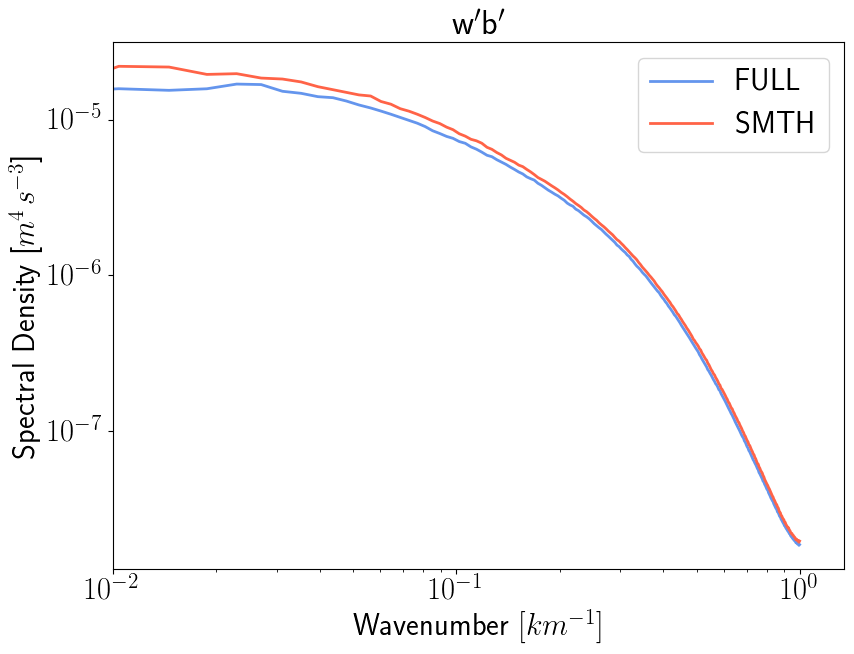

In [28]:

plt.figure(figsize=(9,7))


plt.plot(VBPf.freq_r/dxx,VBPf.mean(axis=0)/dxx*1e3,label='FULL',linewidth=2,color='cornflowerblue') #correcting for m in kr
plt.plot(VBPt.freq_r/dxx,VBPt.mean(axis=0)/dxx*1e3,label='SMTH',linewidth=2,color='tomato')

plt.legend()

plt.yscale('symlog',linthresh=1e-11)
plt.xscale('log')

plt.title('w$^{\prime}$b$^{\prime}$',fontsize=25,fontweight='bold')
plt.ylabel(r'Spectral Density [$m^4\,s^{-3}$]',fontweight='bold')
plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')


plt.xlim(1/100,0)
# plt.ylim(1e-8,1e-1)
# plt.grid()

plt.tight_layout()


# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/total_avg/Total_avg_SURFACE_VBP.png')

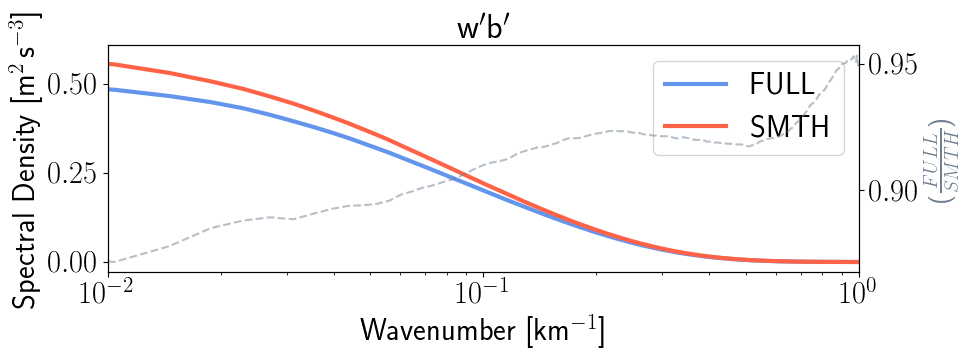

In [29]:
KAf=ogive(VBPf.freq_r/dxx*1e3,np.nanmean(VBPf,axis=0)/dxx*1e3) #in metersss
Kx=VBPf.freq_r/dxx #in Kilometers
KAt=ogive(VBPt.freq_r/dxx*1e3,np.nanmean(VBPt,axis=0)/dxx*1e3)#in metersss

fig,ax = plt.subplots(figsize=(10,4))
ax.plot(Kx,KAf,label='FULL',linewidth=3,color='cornflowerblue')
ax.plot(Kx,KAt,label='SMTH',linewidth=3,color='tomato')
ax.set_title('w$^{\prime}$b$^{\prime}$',fontsize=25,fontweight='bold')

ax.set_xscale('log')

ax.set_xlabel(r'Wavenumber [km$^{-1}$]',fontweight='bold')
ax.set_ylabel(r'Spectral Density [m$^2\,$s$^{-3}$]',fontweight='bold')
ax.set_xlim(1e-2,1)
# ax.set_ylim(-1e-11,4e-11)


ax.legend()

ax2=ax.twinx()
ax2.plot((Kx),((KAf)/(KAt)),alpha=0.5,linestyle='dashed',color='slategrey')
ax2.set_ylabel(r'($\frac{FULL}{SMTH}$)',fontsize=20,color='slategrey')

ax2.set_xscale('log')
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/ogives/ogive_SURFACE_VBP.png')
# 

In [12]:
# N2r=(5.2*10**-3)**2
# N2r=(3.9e-3)**2
N2r=2.1757166666666666e-05 #caculated from FULL

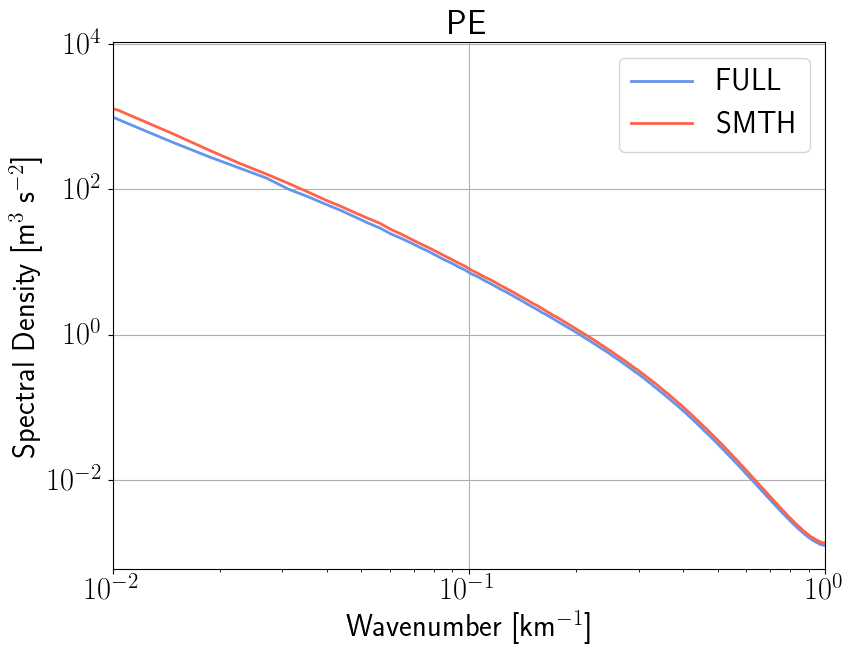

In [21]:
plt.figure(figsize=(9,7))


plt.plot(Bf.freq_r/dxx,(1/(2*N2r))*Bf.mean(axis=0)/dxx*1e3,label='FULL',linewidth=2,color='cornflowerblue') #correcting for m in kr
plt.plot(Bt.freq_r/dxx,(1/(2*N2r))*Bt.mean(axis=0)/dxx*1e3,label='SMTH',linewidth=2,color='tomato')


plt.legend()

plt.yscale('log')
plt.xscale('log')

# plt.title(r'$\frac{1}{2}\,\frac{b^{2}}{N_r^{2}}$',fontweight='bold')
plt.title(r'PE',fontweight='bold',fontsize=25)


plt.ylabel(r'Spectral Density [m$^3$ s$^{-2}$]',fontweight='bold')
plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')


plt.xlim(1/100,1)
# plt.ylim(1e-3,1e3)
plt.grid()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/total_avg/Total_avg_surface_PE.png')

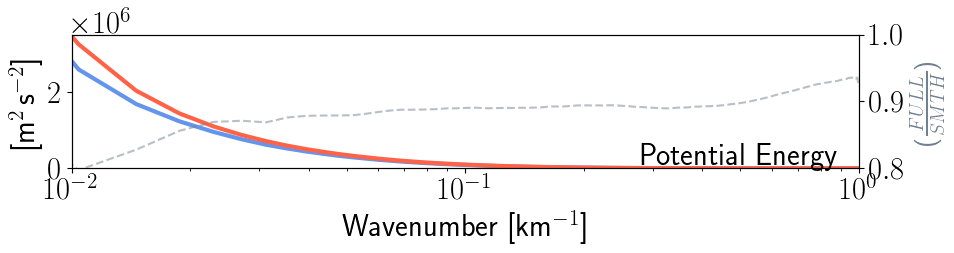

In [13]:
# Kx,Kbf=spec_ogive(spec=np.nanmean((1/(2*N2r))*Bf,axis=0)*dxx*1e3,kr=Bf.freq_r/dxx)
# _,Kbt=spec_ogive(spec=np.nanmean((1/(2*N2r))*Bt,axis=0)*dxx*1e3,kr=Bt.freq_r/dxx)


Kbf=ogive(Bf.freq_r/dxx*1e3,np.nanmean((1/(2*N2r))*Bf,axis=0)/dxx*1e3) #in metersss
Kx=Bf.freq_r/dxx #in Kilometers
Kbt=ogive(Bt.freq_r/dxx*1e3,np.nanmean((1/(2*N2r))*Bt,axis=0)/dxx*1e3)#in metersss



fig,ax = plt.subplots(figsize=(10,3))
ax.plot(Kx,Kbf,label='FULL',linewidth=3,color='cornflowerblue')
ax.plot(Kx,Kbt,label='SMTH',linewidth=3,color='tomato')
# ax.set_title('PE',fontsize=25,fontweight='bold')
ax.text(2.8e-1,0.1e6,'Potential Energy')
ax.set_xscale('log')

ax.set_xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')
ax.set_ylabel(r'[m$^{2}\,$s$^{-2}$]',fontweight='bold')
ax.set_xlim(1e-2,1)
ax.set_ylim(-1e-1,3.5e6)


# ax.legend()

ax2=ax.twinx()
ax2.plot((Kx),((Kbf)/(Kbt)),alpha=0.5,linestyle='dashed',color='slategrey')
ax2.set_ylabel(r'($\frac{FULL}{SMTH}$)',fontsize=20,color='slategrey')
ax2.set_xscale('log')
ax2.set_yticks([0.80,0.90,1])
ax2.set_ylim(0.8,1)
plt.tight_layout()
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/ogives/Ogive_avg_surface_PE.png')

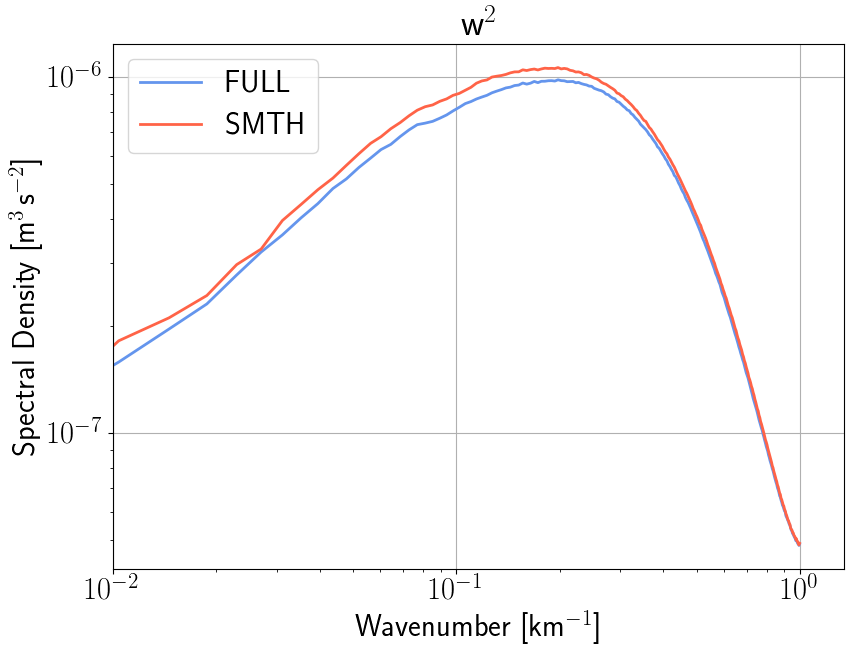

In [44]:

plt.figure(figsize=(9,7))


plt.plot(Wf.freq_r/dxx,Wf.mean(axis=0)/dxx*1e3,label='FULL',linewidth=2,color='cornflowerblue') #correcting for m in kr
plt.plot(Wt.freq_r/dxx,Wt.mean(axis=0)/dxx*1e3,label='SMTH',linewidth=2,color='tomato')

plt.legend()

plt.yscale('log')
plt.xscale('log')

plt.title(r'w$^{2}$',fontweight='bold')
plt.ylabel(r'Spectral Density [m$^3\,$s$^{-2}$]',fontweight='bold')
plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')


plt.xlim(1/100,0)
# plt.ylim(1e-8,1e-1)
plt.grid()

plt.tight_layout()


plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/total_avg/Total_avg_SURFACE_w.png')

# Calculating KE

In [14]:
%%time
uf=varf.u#.groupby("time_counter.dayofyear").mean()
uf=uf.chunk(chunks=chunks_new);
uf=uf.compute();

ut=vart.u#.groupby("time_counter.dayofyear").mean()
ut=ut.chunk(chunks=chunks_new);
ut=ut.compute();

vf=varf.v#.groupby("time_counter.dayofyear").mean()
vf=vf.chunk(chunks=chunks_new);
vf=vf.compute();

vt=vart.v#.groupby("time_counter.dayofyear").mean()
vt=vt.chunk(chunks=chunks_new);
vt=vt.compute();



CPU times: user 14.3 s, sys: 12.5 s, total: 26.8 s
Wall time: 3min 1s


In [15]:
uf,vf,_=romspickle.uvw2rho_3d(uf,vf,uf)
uf,vf=uf[:,120:-120,120:800],vf[:,120:-120,120:800]

ut,vt,_=romspickle.uvw2rho_3d(ut,vt,ut)
ut,vt=ut[:,120:-120,120:800],vt[:,120:-120,120:800]

In [ ]:
with ProgressBar():
    Uf=xrft.isotropic_power_spectrum(uf,dim=['x_u','y_u'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)
    Vf=xrft.isotropic_power_spectrum(vf,dim=['x_v','y_v'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)
    Ut=xrft.isotropic_power_spectrum(ut,dim=['x_u','y_u'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)
    Vt=xrft.isotropic_power_spectrum(vt,dim=['x_v','y_v'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

In [ ]:
Ekef=xr.DataArray(data=0.5*(Uf.data + Vf.data),coords=({'time_counter':Uf.time_counter,'freq_r':Uf.freq_r.data}))
Eket=xr.DataArray(data=0.5*(Ut.data + Vt.data),coords=({'time_counter':Uf.time_counter,'freq_r':Uf.freq_r.data}))

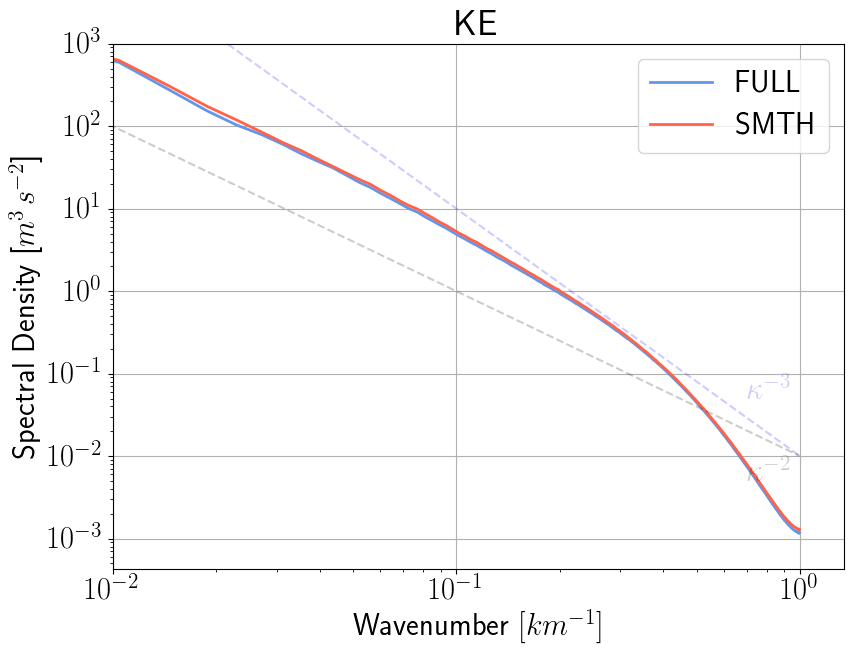

In [33]:
plt.figure(figsize=(9,7))


plt.plot(Ekef.freq_r/dxx,Ekef.mean(axis=0)/dxx*1e3,label='FULL',linewidth=2,color='cornflowerblue')
plt.plot(Eket.freq_r/dxx,Eket.mean(axis=0)/dxx*1e3,label='SMTH',linewidth=2,color='tomato')

k2 = np.array([Ekef.freq_r[0],Ekef.freq_r[-1]])/dxx
E2 = ((1/k2)**2)*(1e-2)

k3 = np.array([Ekef.freq_r[0],Ekef.freq_r[-1]])/dxx
E3 = ((1/k3)**3)*(1e-2)


plt.plot(k2,E2,'k--',alpha=0.2)
plt.text(0.7,0.5e-2,r'$\kappa^{-2}$',weight='normal',alpha=0.2)

plt.plot(k3,E3,'b--',alpha=0.2)
plt.text(0.7,5e-2,r'$\kappa^{-3}$',weight='normal',color='b',alpha=0.2)

plt.grid()


plt.yscale('log')
plt.xscale('log')
plt.legend()

plt.title('KE',fontweight='bold')
plt.ylabel(r'Spectral Density [$m^3\,s^{-2}$]',fontweight='bold')
plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')

plt.xlim(1e-2,0)
plt.ylim(0,1e3)
plt.tight_layout()

plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/total_avg/Total_avg_SURFACE_KE.png')

In [ ]:
KAf=ogive(Ekef.freq_r/dxx*1e3,np.nanmean(Ekef,axis=0)/dxx*1e3) #in metersss
Kx=Ekef.freq_r/dxx #in Kilometers
KAt=ogive(Eket.freq_r/dxx*1e3,np.nanmean(Eket,axis=0)/dxx*1e3)#in metersss



fig,ax = plt.subplots(figsize=(10,3))
ax.plot((Kx),KAf,label='FULL',linewidth=3,color='cornflowerblue')
ax.plot((Kx),KAt,label='SMTH',linewidth=3,color='tomato')
# ax.set_title('KE (Ogive)',fontsize=15,fontweight='bold')


ax.set_xscale('log')

ax.text(3e-1,0.1e6,'Kinetic Energy')



# ax.set_xticks(np.array([-2,-1]))
# ax.set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])


ax.set_xlabel(r'Wavenumber [km$^{-1}$]',fontweight='bold')
ax.set_ylabel(r'[m$^2\,$s$^{-2}$]',fontweight='bold')
# ax.set_title(r'KE',fontsize=25)
ax.set_xlim(1e-2,1)
ax.set_ylim(-0.1,2e6)



# ax.legend()

ax2=ax.twinx()
# ax2.plot((Kx),((KAf)/(KAt)-1)*100,alpha=0.5,linestyle='dashed',color='cadetblue')
ax2.plot((Kx),((KAf)/(KAt)),alpha=0.5,linestyle='dashed',color='slategrey')
ax2.set_ylim(0.901,1)



ax2.set_ylabel(r'($\frac{FULL}{SMTH}$)',fontweight='bold',fontsize=20,color='slategrey')
ax2.set_xscale('log')
ax2.set_yticks([0.80,0.90,1])
ax2.set_ylim(0.8,1)
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/ogives/Ogive_avg_KE.png')

### Monthly Averages

In [31]:
#fig, axs = plt.subplots(4,2, figsize=(15, 13.5), facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = 1, wspace=.01)

# axs = axs.ravel()

# for ipp in range(len(mes)):

#     axs[ipp].plot((Ekef.freq_r/dxx),(np.nanmean(Ekef[mon_ind==mes[ipp],:],axis=0)),label='FULL',linewidth=2,color='navy')
#     axs[ipp].plot((Eket.freq_r/dxx),(np.nanmean(Eket[mon_ind==mes[ipp],:],axis=0)),label='SMTH',linewidth=2,color='lightcoral')
#     # axs[ipp].plot((k3),(E3),'k--',alpha=0.4)
#     # axs[0].text(-1.5,-2.5,r'$\kappa^{-3}$',alpha=0.1,weight='light')
#     # axs[ipp].grid()
#     axs[ipp].set_xscale('log')
#     axs[ipp].set_yscale('log')



#     axs[ipp].set_title(mes_str[ipp])
#     # axs[ipp].set_xticks(np.array([-2,-1]))
#     # axs[ipp].set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])
#     # axs[ipp].set_yticks(np.array([-5,-3,-1,1,3]))
#     # axs[ipp].set_yticklabels([r'10$^{-5}$',r'10$^{-3}$',r'10$^{-1}$',r'10$^{1}$',r'10$^{3}$'])
#     if ipp in [0,2,4,6]:
#         axs[ipp].set_ylabel(r'$E(k)$',color="k",fontsize=18,fontweight='bold')
#     if ipp in [6,7]:
#         axs[ipp].set_xlabel(r'Wavenumber $ [km^{-1}]$',fontsize=18,fontweight='bold')

#     axs[0].legend()


#     axs[ipp].set_xlim(1e-2,0)
#     # axs[ipp].set_ylim(-6,-1)


# plt.tight_layout()
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/monthly_KE.png')

## Windwork

In [56]:
usf=varf.sustr#.groupby("time_counter.dayofyear").mean()
usf=usf.chunk(chunks=chunks_new);
usf=usf.compute();



ust=vart.sustr#.groupby("time_counter.dayofyear").mean()
ust=ust.chunk(chunks=chunks_new);
ust=ust.compute();



vsf=varf.svstr#.groupby("time_counter.dayofyear").mean()
vsf=vsf.chunk(chunks=chunks_new);
vsf=vsf.compute();


vst=vart.svstr#.groupby("time_counter.dayofyear").mean()
vst=vst.chunk(chunks=chunks_new);
vst=vst.compute();

In [57]:
usf,vsf,_=romspickle.uvw2rho_3d(usf,vsf,usf)
ust,vst,_=romspickle.uvw2rho_3d(ust,vst,vst)

usf,vsf=usf[:,120:-120,120:800],vsf[:,120:-120,120:800]
ust,vst=ust[:,120:-120,120:800],vst[:,120:-120,120:800]

In [59]:
nfw=2
with ProgressBar():
    Xf=xrft.isotropic_cross_spectrum(usf,uf,
                                      dim=['y_u','x_u'],nfactor=nfw,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real

    Yf=xrft.isotropic_cross_spectrum(vsf,vf,
                                      dim=['y_v','x_v'],nfactor=nfw,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real


    Xt=xrft.isotropic_cross_spectrum(ust,ut,
                                      dim=['y_u','x_u'],nfactor=nfw,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real

    Yt=xrft.isotropic_cross_spectrum(vst,vt,
                                      dim=['y_v','x_v'],nfactor=nfw,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real



In [61]:

WWf=xr.DataArray(data=(1/1024)*(Xf.real.data + Yf.real.data),coords=({'time_counter':Xf.time_counter,'freq_r':Xf.freq_r.data}));
WWt=xr.DataArray(data=(1/1024)*(Xt.real.data + Yt.real.data),coords=({'time_counter':Xf.time_counter,'freq_r':Xf.freq_r.data}));

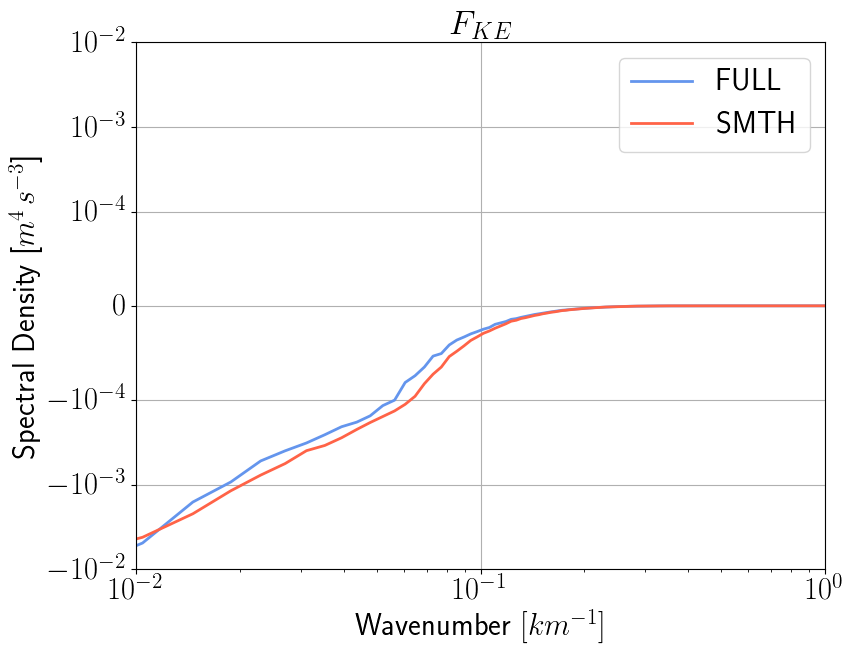

In [63]:

plt.figure(figsize=(9,7))


plt.plot((WWf.freq_r/dxx),(np.nanmean(WWf,axis=0))*(dxx*1e3),label='FULL',linewidth=2,color='cornflowerblue')
plt.plot((WWt.freq_r/dxx),(np.nanmean(WWt,axis=0))*(dxx*1e3),label='SMTH',linewidth=2,color='tomato')
# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend()

plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')
plt.ylabel(r'Spectral Density [$m^4\,s^{-3}$]',fontweight='bold')

plt.title(r'$F_{KE}$',fontsize=25,fontweight='bold')
plt.yscale('symlog', linthresh=1e-4)
plt.xscale('log')

plt.ylim(-1e-2,1e-2)
plt.xlim(1e-2,1)
plt.grid()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/total_avg/Total_avg_Windwork_KE.png')


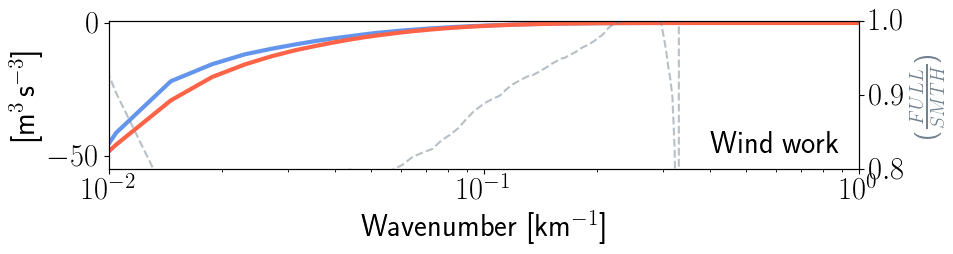

In [81]:


WWpf=ogive(WWf.freq_r/dxx*1e3,np.nanmean(WWf,axis=0)/dxx*1e3) #in metersss
Kx=WWf.freq_r/dxx #in Kilometers
WWpt=ogive(WWt.freq_r/dxx*1e3,np.nanmean(WWt,axis=0)/dxx*1e3)#in metersss




fig,ax = plt.subplots(figsize=(10,3))

ax.plot(Kx,WWpf,label='FULL',linewidth=3,color='cornflowerblue')
ax.plot(Kx,WWpt,label='SMTH',linewidth=3,color='tomato')

ax.set_xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')
# ax.set_ylabel(r'Spectral Density [m$^3\,$s$^{-3}$]',fontweight='bold')
ax.set_ylabel(r'[m$^3\,$s$^{-3}$]',fontweight='bold')


# ax.set_title(r'$F_{KE}$',fontsize=25,fontweight='bold')
ax.text(4e-1,-49,'Wind work')

ax.set_xscale('log')

# ax.set_xticks(np.array([-2,-1]))
# ax.set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])
ax.set_ylim(-55,0.9)
ax.set_xlim(1e-2,1)
# ax.legend(loc=4)
decx=1
ax2=ax.twinx()
# ax2.plot(Kx[::decx],(np.abs(WWpf)/np.abs(WWpt))[::decx],alpha=0.5,linestyle='dashed',color='slategrey')

ax2.plot(Kx[::decx],((WWpf)/(WWpt))[::decx],alpha=0.5,linestyle='dashed',color='slategrey')


ax2.set_ylabel(r'($\frac{FULL}{SMTH}$)',fontsize=20,color='slategrey')
# ax2.set_ylim(0.79,1)
ax2.set_xscale('log')
ax2.set_yticks([0.80,0.90,1])
ax2.set_ylim(0.8,1)
# plt.grid()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/ogives/Ogive_avg_Windwork.png')




## Energy Ratio

### Panel Figure

In [36]:
PeM_f=(1/(2*N2r))*Bf.mean(axis=0)
PeM_t=(1/(2*N2r))*Bt.mean(axis=0)

KeM_f=Ekef.mean(axis=0)
KeM_t=Eket.mean(axis=0)

R_f=PeM_f.data/KeM_f.data
R_t=PeM_t.data/KeM_t.data

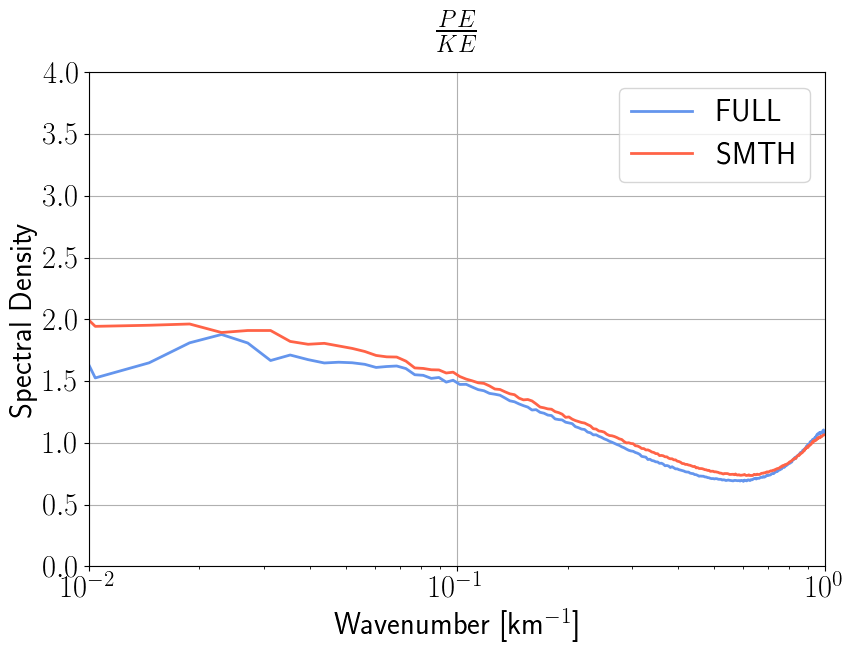

In [37]:

plt.figure(figsize=(9,7))


plt.plot((Ekef.freq_r/dxx),R_f,label='FULL',linewidth=2,color='cornflowerblue')
plt.plot((Eket.freq_r/dxx),R_t,label='SMTH',linewidth=2,color='tomato')
# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend()

plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')
plt.ylabel(r'Spectral Density',fontweight='bold')

plt.title(r'$\frac{PE}{KE}$',fontsize=25,fontweight='bold',y=1.05)
# plt.yscale('symlog', linthresh=1e-4)
plt.xscale('log')

plt.ylim(0,4)
plt.xlim(1e-2,1)
plt.grid()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/total_avg/Ratio_PE-KE.png')



### Potential energy from Thermal

In [39]:
tf=varf.temp#.groupby("time_counter.dayofyear").mean()
tf=tf.chunk(chunks=chunks_new);
tf=tf[:,120:-120,120:800].compute();

tt=vart.temp#.groupby("time_counter.dayofyear").mean()
tt=tt.chunk(chunks=chunks_new);
tt=tt[:,120:-120,120:800].compute();



sf=varf.salt#.groupby("time_counter.dayofyear").mean()
sf=sf.chunk(chunks=chunks_new);
sf=sf[:,120:-120,120:800].compute();

st=vart.salt#.groupby("time_counter.dayofyear").mean()
st=st.chunk(chunks=chunks_new);
st=st[:,120:-120,120:800].compute();



In [40]:
import seawater as sw
# alpha_f2=(sw.alpha(sf,tf,p=0))**2
# alpha_t2=(sw.alpha(st,tt,p=0))**2
# g2=9.8**2

alpha_full=(sw.alpha(sf,tf,p=0))
alpha_smth=(sw.alpha(st,tt,p=0))
g=9.8

In [41]:
buoyancy_temp_full=alpha_full*g*(tf-tf.mean(axis=1).mean(axis=1))
buoyancy_temp_smth=alpha_smth*g*(tt-tt.mean(axis=1).mean(axis=1))

In [42]:

with ProgressBar():
    B_T_f=xrft.isotropic_power_spectrum(buoyancy_temp_full.drop(['nav_lat_rho','nav_lon_rho','time_counter']),
                                      dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

    B_T_t=xrft.isotropic_power_spectrum(buoyancy_temp_smth.drop(['nav_lat_rho','nav_lon_rho','time_counter']),
                                      dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

In [43]:
PetM_f=(1/(2*N2r))*(B_T_f).mean(axis=0)
PetM_t=(1/(2*N2r))*(B_T_t).mean(axis=0)


R_f=PetM_f.data/KeM_f.data
R_t=PetM_t.data/KeM_t.data

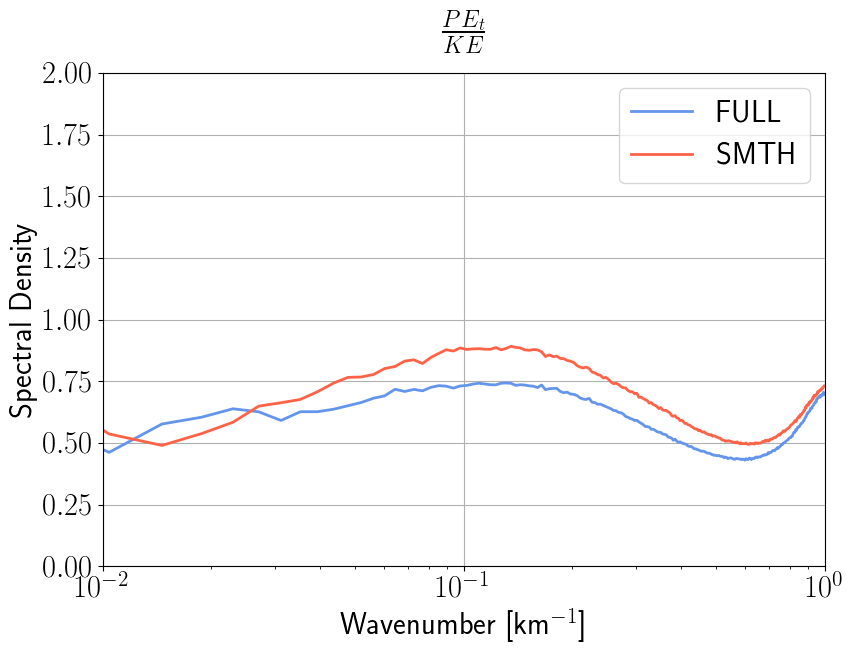

In [44]:

plt.figure(figsize=(9,7))


plt.plot((Ekef.freq_r/dxx),R_f,label='FULL',linewidth=2,color='cornflowerblue')
plt.plot((Eket.freq_r/dxx),R_t,label='SMTH',linewidth=2,color='tomato')
# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend()

plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')
plt.ylabel(r'Spectral Density',fontweight='bold')


plt.title(r'$\frac{PE_t}{KE}$',fontsize=25,fontweight='bold',y=1.05)
# plt.yscale('symlog', linthresh=1e-4)
plt.xscale('log')

plt.ylim(0,2)
plt.xlim(1e-2,1)
plt.grid()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/total_avg/Ratio_PEt-KE.png')
